In [0]:
#load packages
import numpy as np
import tensorflow as tf
import pickle as pl
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
#Load Datasets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
#mnist = !unzip MNIST_data.zip

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [21]:
#formulas for transposed convolutions output
# # Padding==Same:
# #H = H1 * stride

# # Padding==Valid
# #H = (H1-1) * stride + HF

(1, 7, 7, 64)


# New Section

In [0]:
tf.reset_default_graph()

#Function to create generator and discrimninator inputs

def input_mnist(input_size, z_size):
    
    input_real = tf.placeholder(tf.float32,[None, *input_size])
    
    input_gen = tf.placeholder(tf.float32, [None, z_size])
    
    
    return input_real, input_gen
    
    
    

In [0]:
#Function to create generator forward pass



def generator_forward(z, reuse=False, training=True):
  
    with tf.variable_scope('generator', reuse=reuse):
      
        # First fully connected layer
        x1 = tf.contrib.layers.fully_connected(z, 3 * 3 * 512, activation_fn = None)
        x1 = tf.reshape(x1, [-1, 3, 3, 512])
        x1 = tf.layers.batch_normalization(x1, training = training)
        x1 = tf.nn.relu(x1)
        # 3x 3 x 512
        
        #conv layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides = 2, padding = 'VALID')
        x2 = tf.layers.batch_normalization(x2, training = training)
        x2 = tf.nn.relu(x2)
        #7 X 7 X 256
        
        #CONV layer
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides = 2, padding = 'SAME')
        x3 = tf.layers.batch_normalization(x3, training = training)
        x3 = tf.nn.relu(x3)
        #14 X 14 X 128
        
        #CONV layer
        logits = tf.layers.conv2d_transpose(x3, 1, 3, strides = 2, padding = 'SAME')
        #28 X 28 X 1
        
        out = tf.tanh(logits)
        
        return out
      
      
      
    

In [0]:
#Function to create discriminator forward pass

def discriminator_forward(x, reuse=False, alpha=0.2):
  
    with tf.variable_scope('discriminator', reuse=reuse):
      
        # Input layer is 28x28x1
        
        x1 = tf.layers.conv2d(x, filters = 128, kernel_size = 3, strides = 2, padding =  'SAME')
        x1 = tf.maximum(alpha * x1, x1)
        #14 x 14 x 128
        
        x2 = tf.layers.conv2d(x1, filters = 256, kernel_size = 3, strides = 2, padding =  'SAME')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha * x2, x2)
        #7 x 7 x 256
        
        x3 = tf.layers.conv2d(x2, filters = 512, kernel_size = 3, strides = 2, padding =  'SAME')
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)
        #4 x 4 x 512
        
        flat = tf.reshape(x3, [-1, 4*4*512])
        logits = tf.contrib.layers.fully_connected(flat, 1, activation_fn = None)
        
        out = tf.nn.sigmoid(logits)
        
        return logits, out

In [0]:
#Defining model paramaters for tensorflow graph
#input_size = 784
z_size = 100
smoothing = 0.1
input_size = (28, 28, 1)

In [0]:
#Building graph parameters
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    
    input_real, input_gen = input_mnist(input_size, z_size)
    
    Gout = generator_forward(input_gen, reuse=False, training=True)
    
    D_logits_real, D_out_real = discriminator_forward(input_real, reuse=False, alpha=0.2)
    
    D_logits_fake, D_out_fake = discriminator_forward(Gout, reuse = True, alpha = 0.2)
    

In [0]:
#Defining Cost Function for the Discriminator and Generator


    
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = (tf.ones_like(D_logits_real) * (1 -smoothing)), 
                                                                         logits = D_logits_real))
    
    
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(D_logits_fake), 
                                                                         logits = D_logits_fake))
    
    
    D_loss_total = D_loss_real + D_loss_fake
        
        
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(D_logits_fake), 
                                                                         logits = D_logits_fake))
    
        


In [0]:
#Building our optimizers in two stages

learning_rate = 0.0002
batch_size = 128
alpha = 0.2
beta1 = 0.5


with graph.as_default():
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      
        D_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(D_loss_total, var_list=d_vars)
        G_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(G_loss, var_list=g_vars)


Epoch is 1/100 Generator loss: 1.752013..... Discriminator loss: 0.586067..


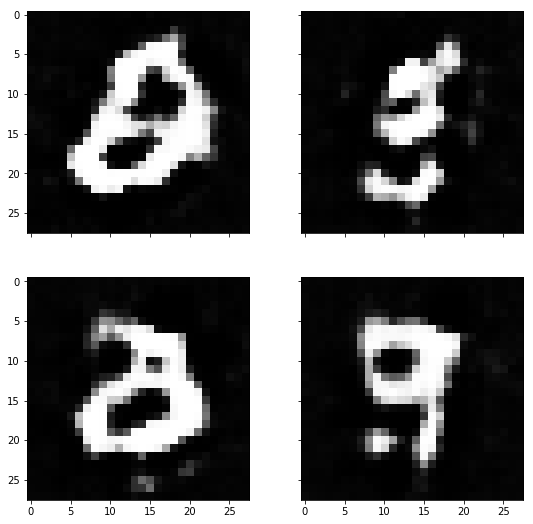

Epoch is 2/100 Generator loss: 1.585221..... Discriminator loss: 0.749797..


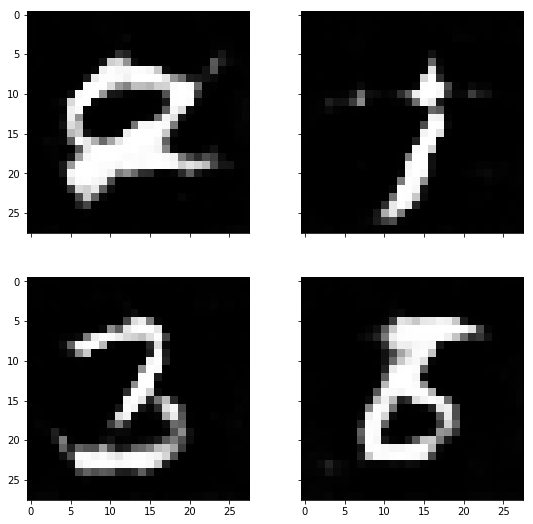

Epoch is 3/100 Generator loss: 1.300493..... Discriminator loss: 0.815590..


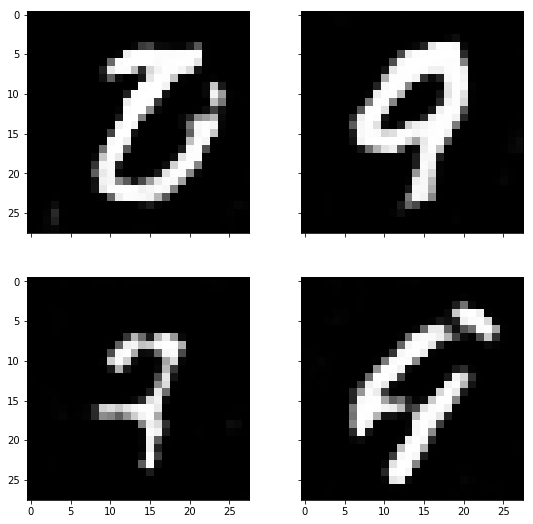

Epoch is 4/100 Generator loss: 0.873185..... Discriminator loss: 0.993747..


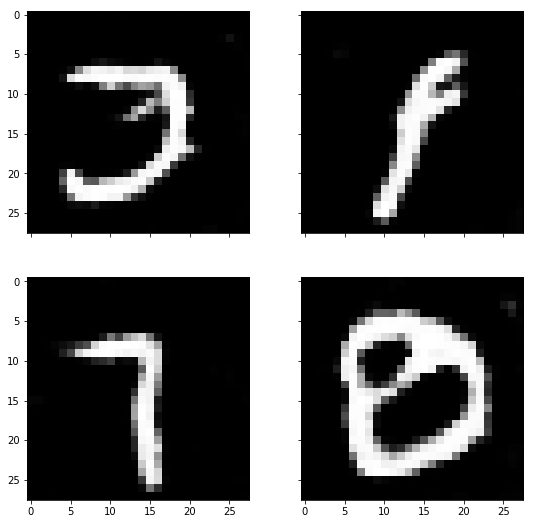

Epoch is 5/100 Generator loss: 1.095414..... Discriminator loss: 0.924290..


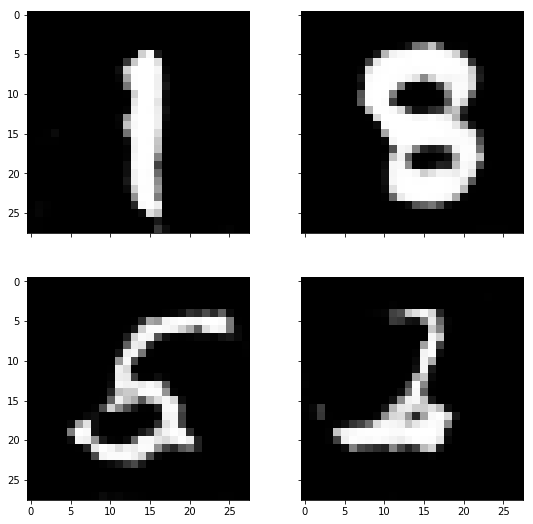

Epoch is 6/100 Generator loss: 1.101754..... Discriminator loss: 1.017842..


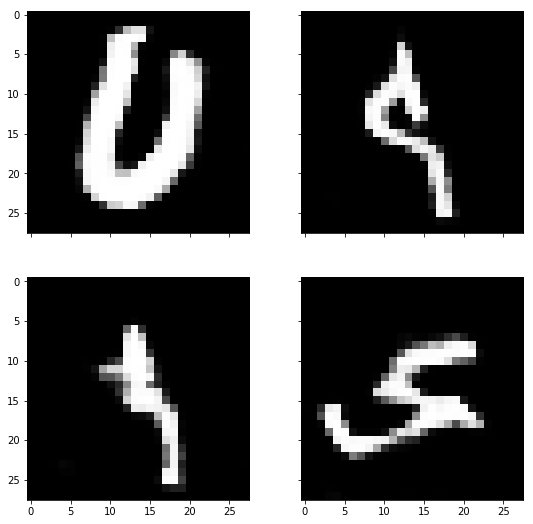

Epoch is 7/100 Generator loss: 1.768490..... Discriminator loss: 0.888663..


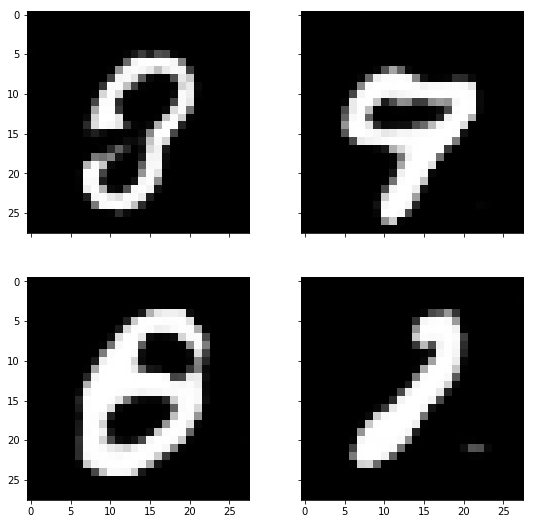

Epoch is 8/100 Generator loss: 1.518549..... Discriminator loss: 1.117343..


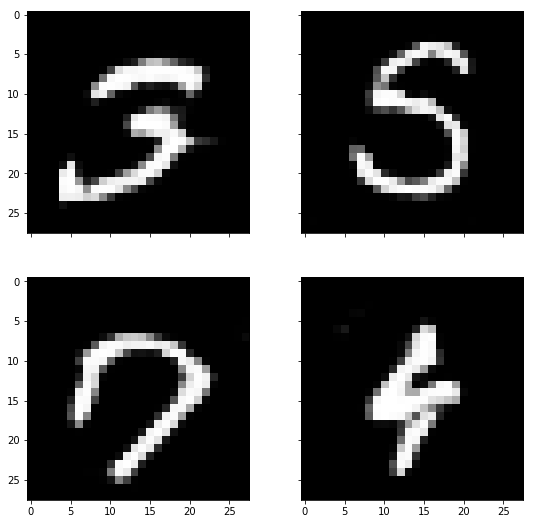

Epoch is 9/100 Generator loss: 1.416498..... Discriminator loss: 0.856915..


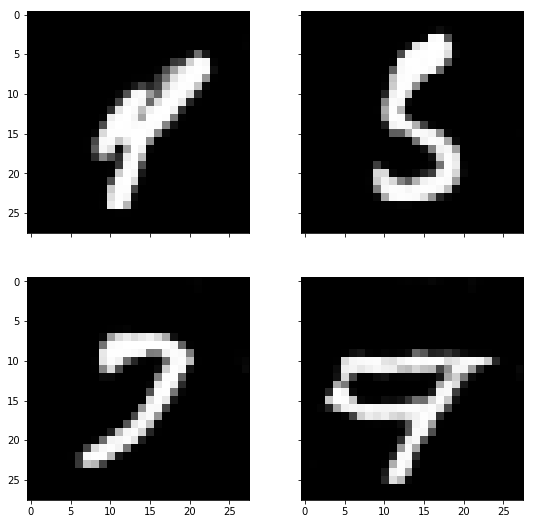

Epoch is 10/100 Generator loss: 2.491088..... Discriminator loss: 1.091466..


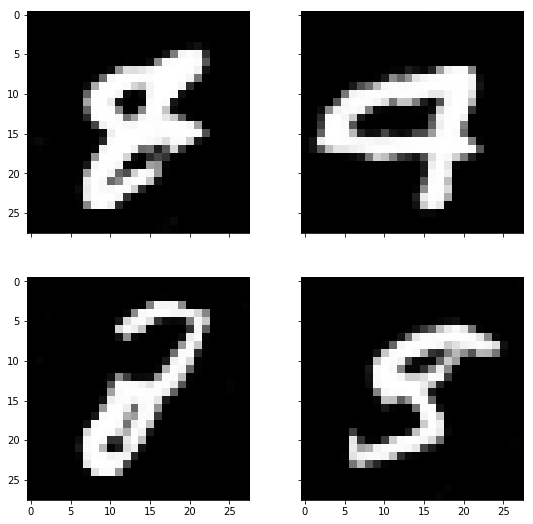

Epoch is 11/100 Generator loss: 2.185950..... Discriminator loss: 1.023168..


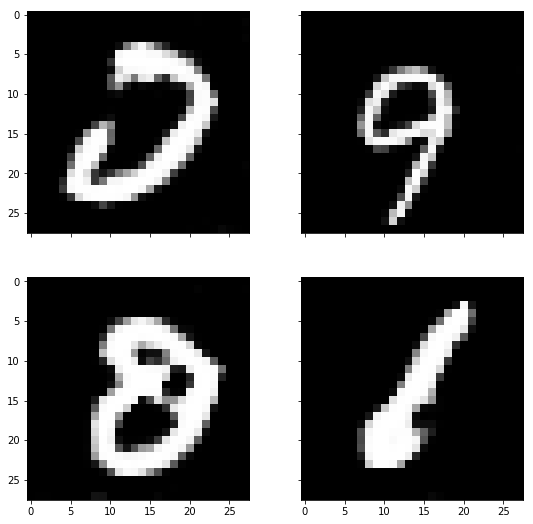

Epoch is 12/100 Generator loss: 1.227468..... Discriminator loss: 0.820964..


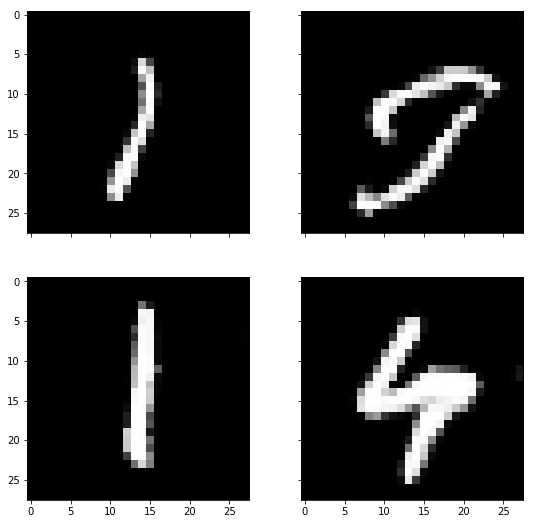

Epoch is 13/100 Generator loss: 1.054172..... Discriminator loss: 0.985777..


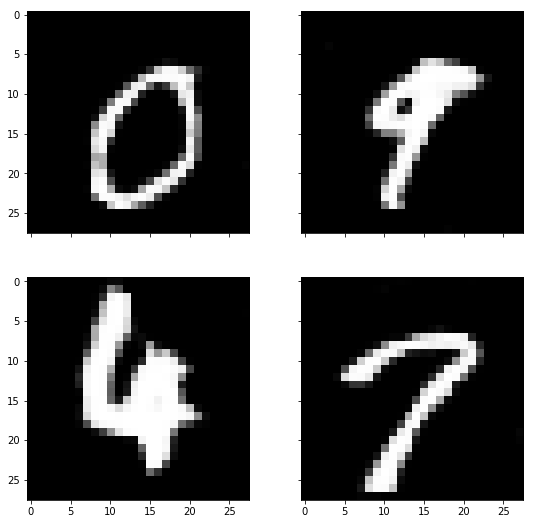

Epoch is 14/100 Generator loss: 0.719245..... Discriminator loss: 1.147271..


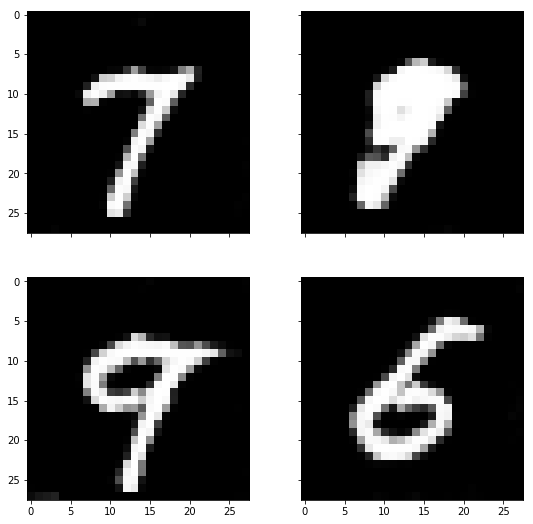

Epoch is 15/100 Generator loss: 1.566573..... Discriminator loss: 0.892419..


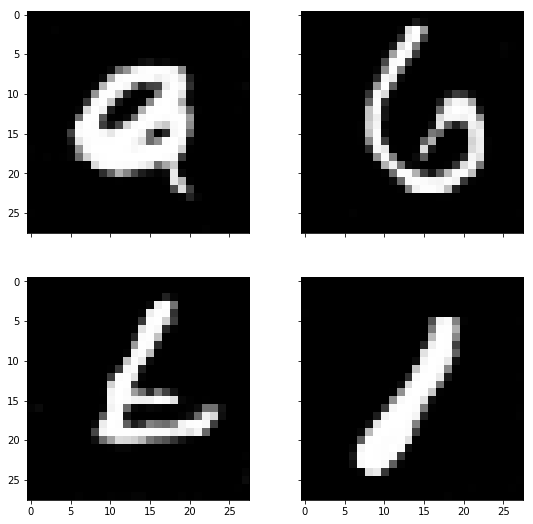

Epoch is 16/100 Generator loss: 1.480358..... Discriminator loss: 0.772329..


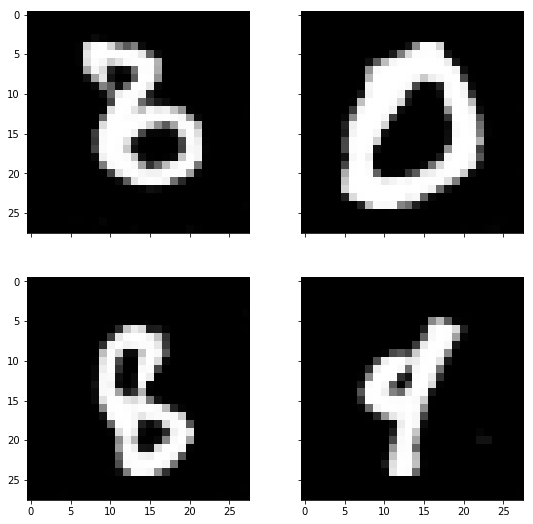

Epoch is 17/100 Generator loss: 1.528105..... Discriminator loss: 0.734374..


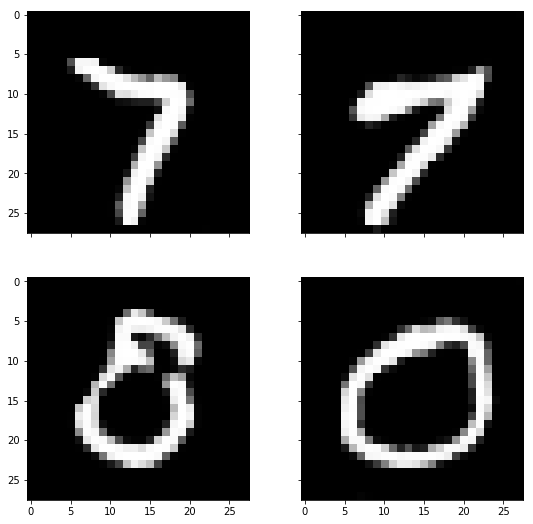

Epoch is 18/100 Generator loss: 1.221833..... Discriminator loss: 0.821557..


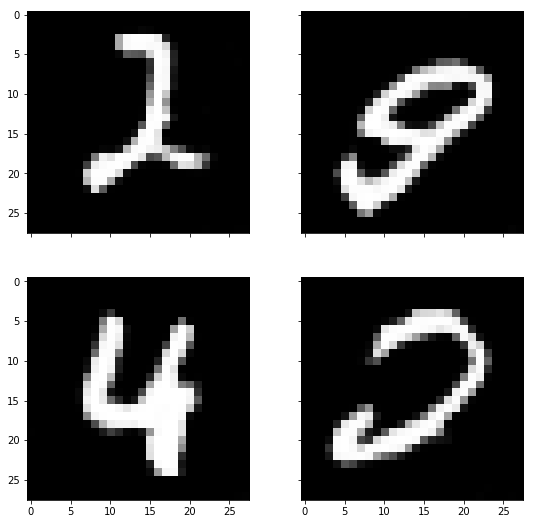

Epoch is 19/100 Generator loss: 0.642944..... Discriminator loss: 1.258227..


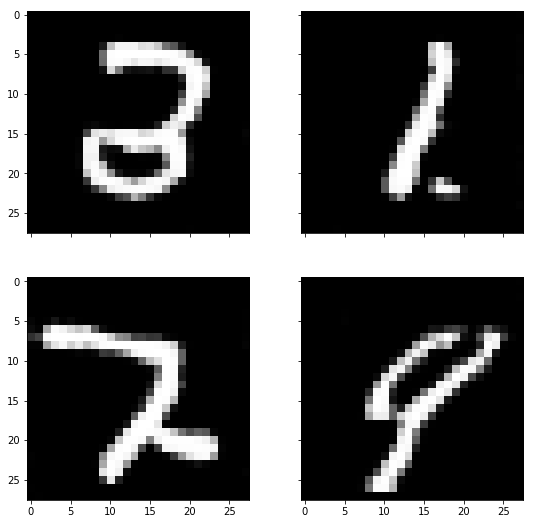

Epoch is 20/100 Generator loss: 1.099701..... Discriminator loss: 0.906475..


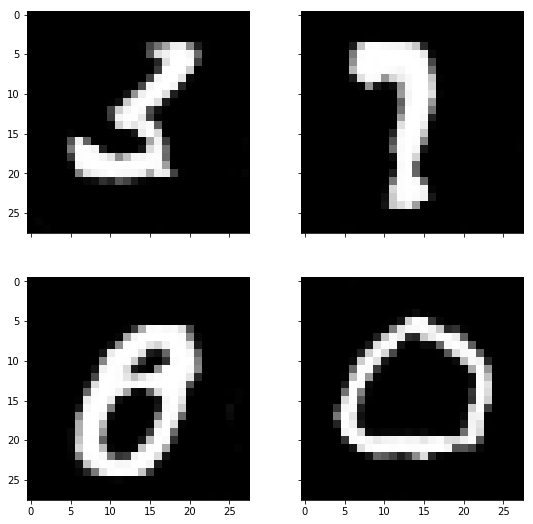

Epoch is 21/100 Generator loss: 1.567568..... Discriminator loss: 0.836594..


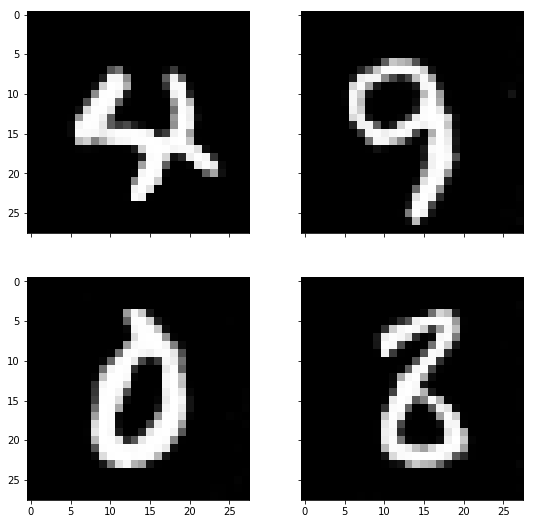

Epoch is 22/100 Generator loss: 1.540059..... Discriminator loss: 0.700884..


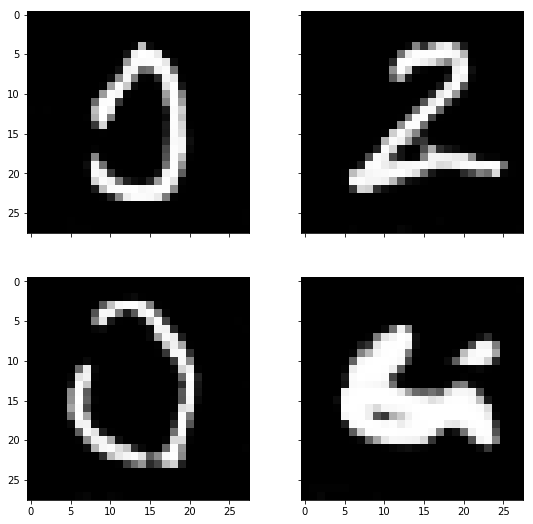

Epoch is 23/100 Generator loss: 1.379894..... Discriminator loss: 0.796288..


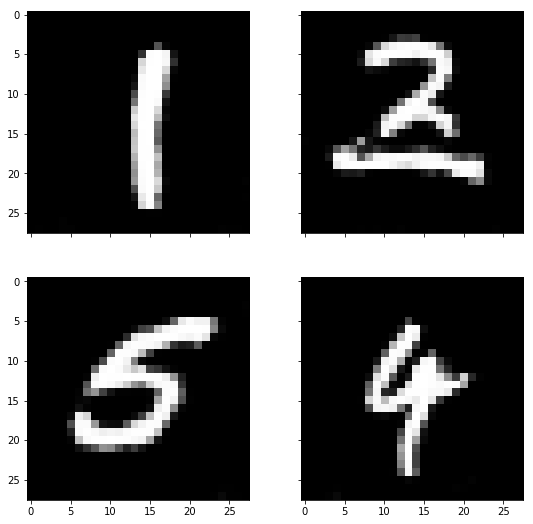

Epoch is 24/100 Generator loss: 1.414091..... Discriminator loss: 0.758664..


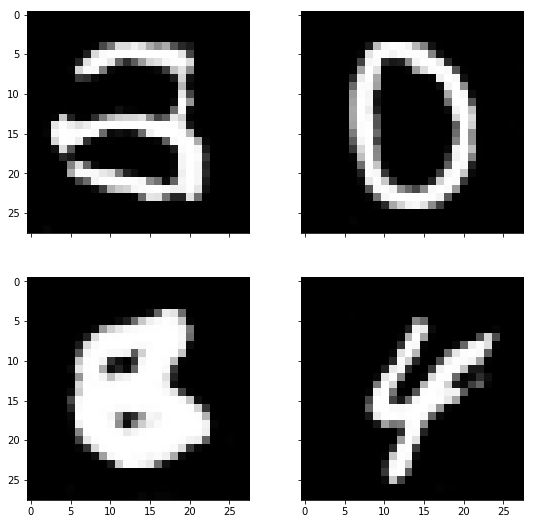

Epoch is 25/100 Generator loss: 1.197255..... Discriminator loss: 0.871758..


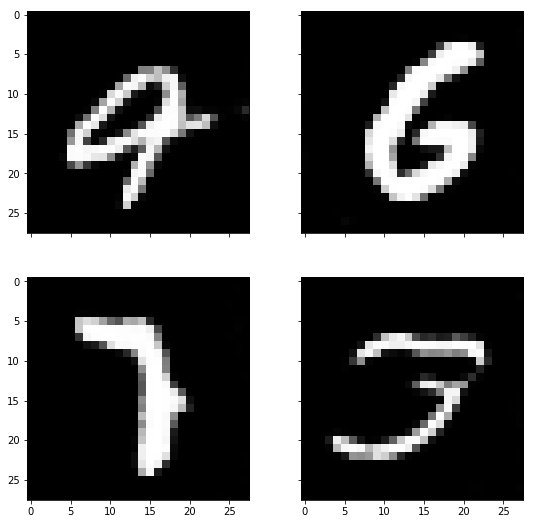

Epoch is 26/100 Generator loss: 0.891339..... Discriminator loss: 1.070008..


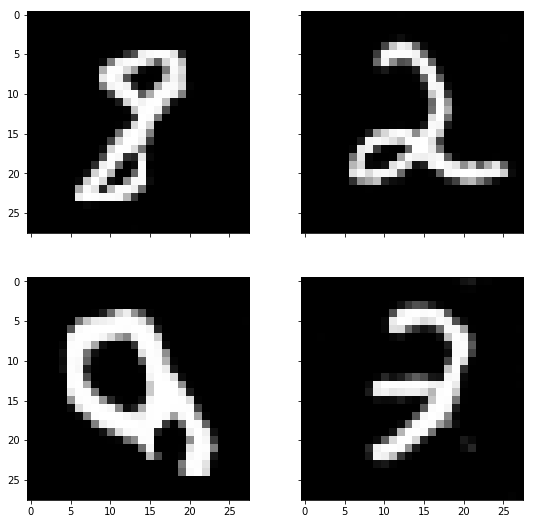

Epoch is 27/100 Generator loss: 1.355517..... Discriminator loss: 0.761640..


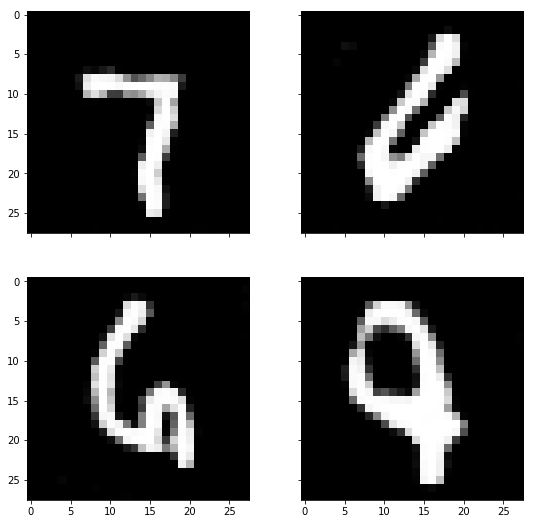

Epoch is 28/100 Generator loss: 1.235132..... Discriminator loss: 0.829054..


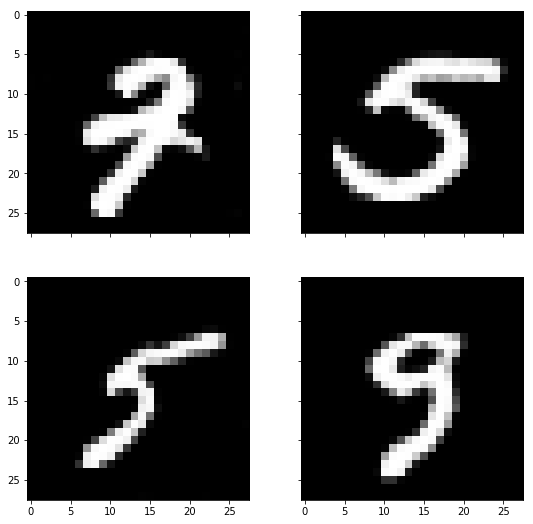

Epoch is 29/100 Generator loss: 0.946133..... Discriminator loss: 0.943885..


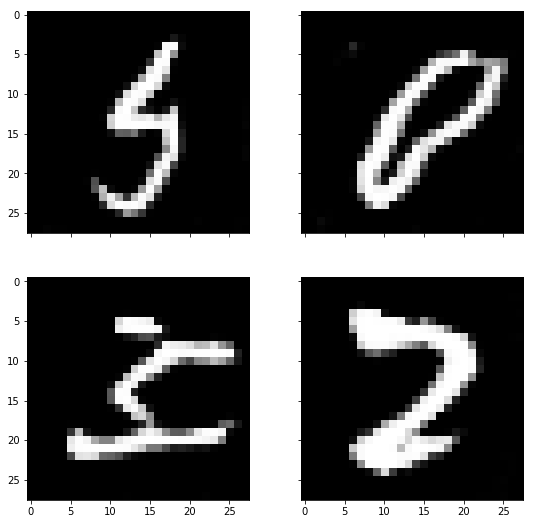

Epoch is 30/100 Generator loss: 1.361894..... Discriminator loss: 0.890193..


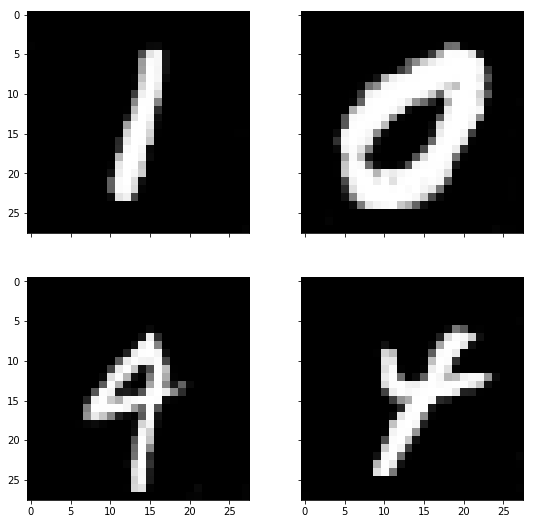

Epoch is 31/100 Generator loss: 0.917097..... Discriminator loss: 0.988269..


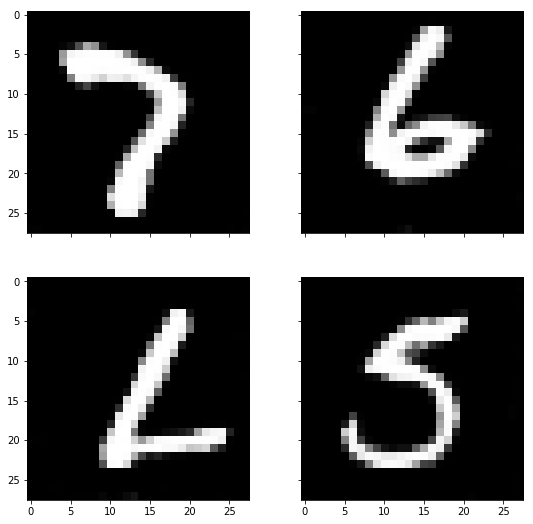

Epoch is 32/100 Generator loss: 0.993736..... Discriminator loss: 0.939353..


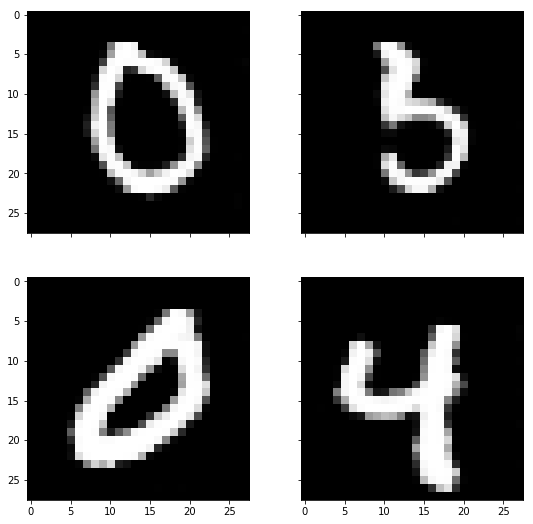

Epoch is 33/100 Generator loss: 1.870345..... Discriminator loss: 0.604293..


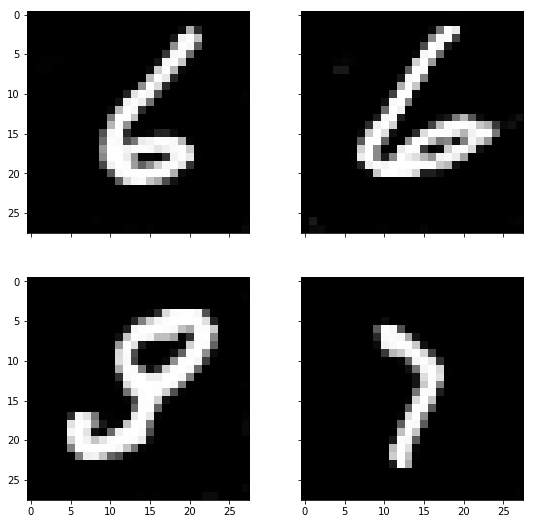

Epoch is 34/100 Generator loss: 2.120252..... Discriminator loss: 0.686738..


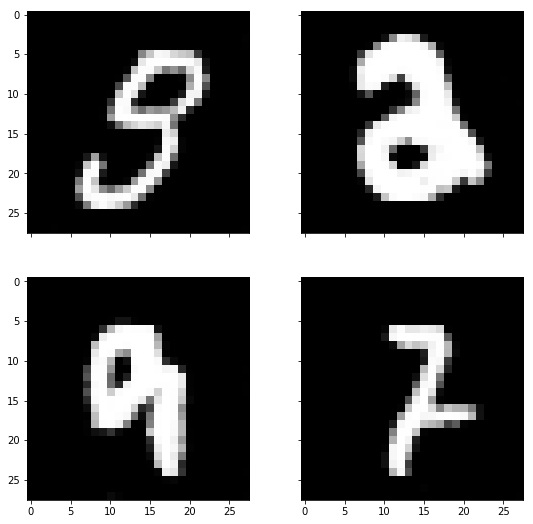

Epoch is 35/100 Generator loss: 0.691060..... Discriminator loss: 1.243355..


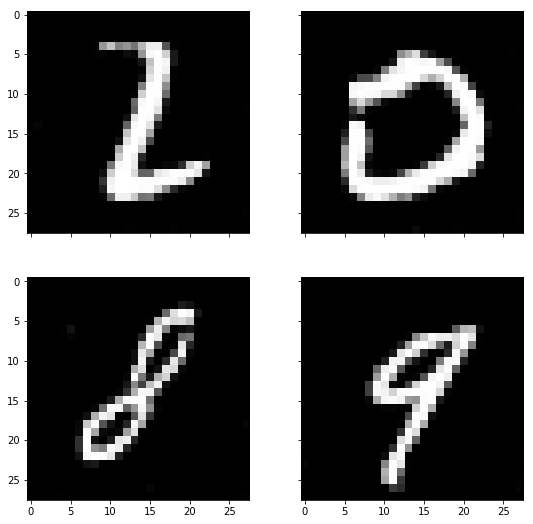

Epoch is 36/100 Generator loss: 0.949047..... Discriminator loss: 0.968908..


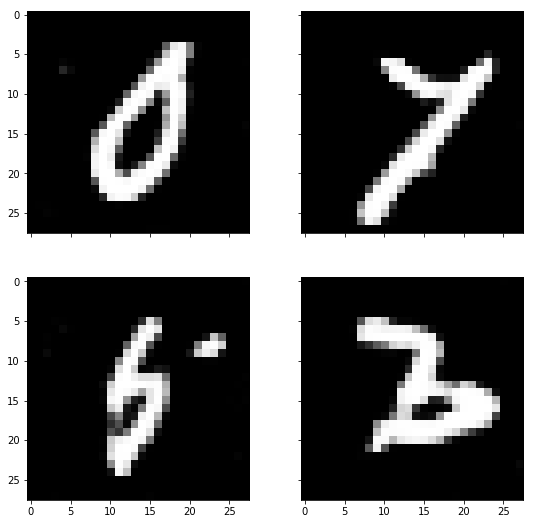

Epoch is 37/100 Generator loss: 0.829304..... Discriminator loss: 1.267708..


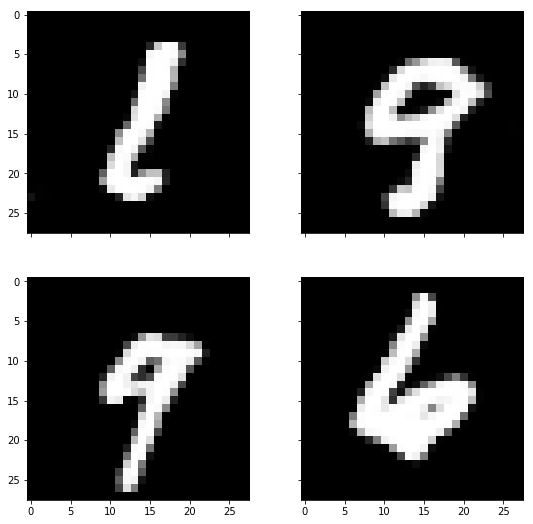

Epoch is 38/100 Generator loss: 1.372101..... Discriminator loss: 0.738530..


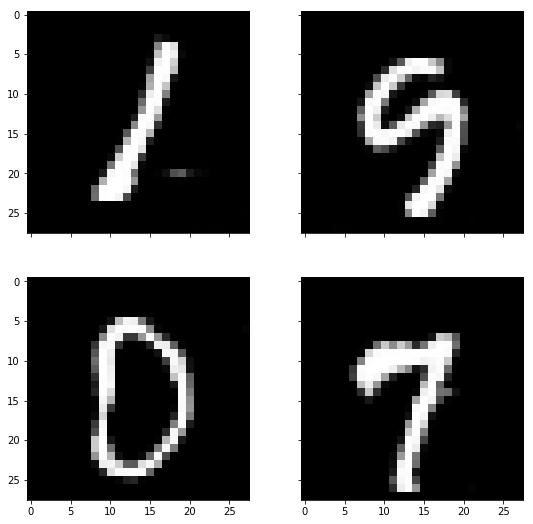

Epoch is 39/100 Generator loss: 0.857284..... Discriminator loss: 1.044619..


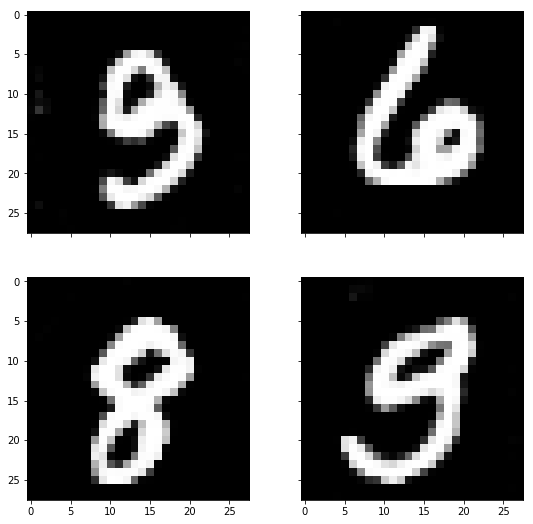

Epoch is 40/100 Generator loss: 1.156942..... Discriminator loss: 0.834461..


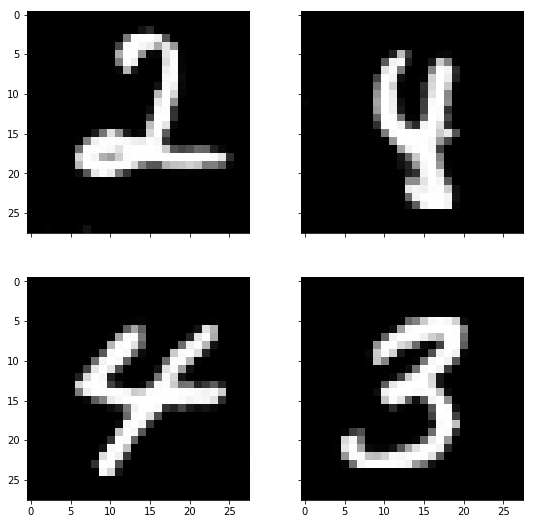

Epoch is 41/100 Generator loss: 0.929992..... Discriminator loss: 1.007915..


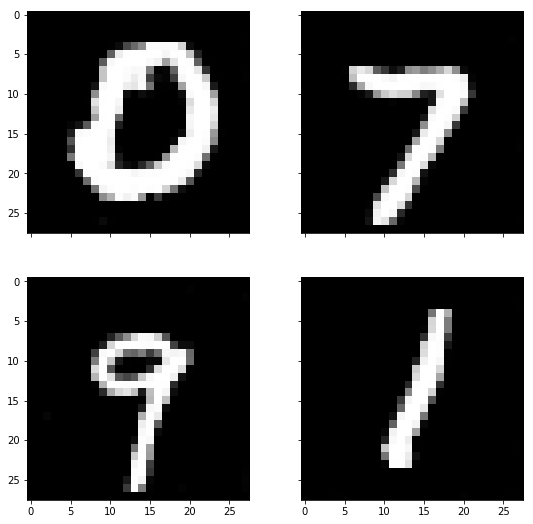

Epoch is 42/100 Generator loss: 2.133299..... Discriminator loss: 0.850445..


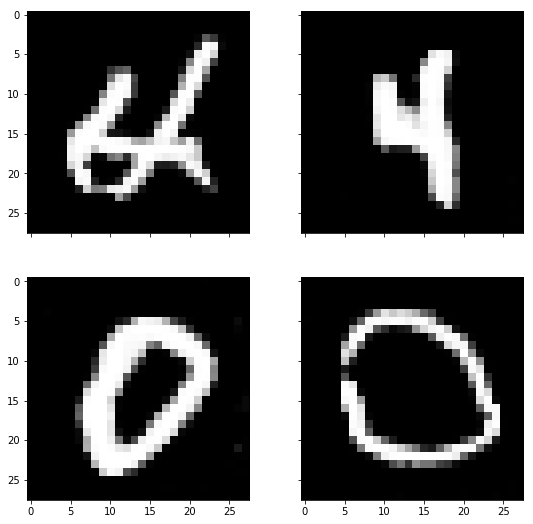

Epoch is 43/100 Generator loss: 1.273932..... Discriminator loss: 0.813812..


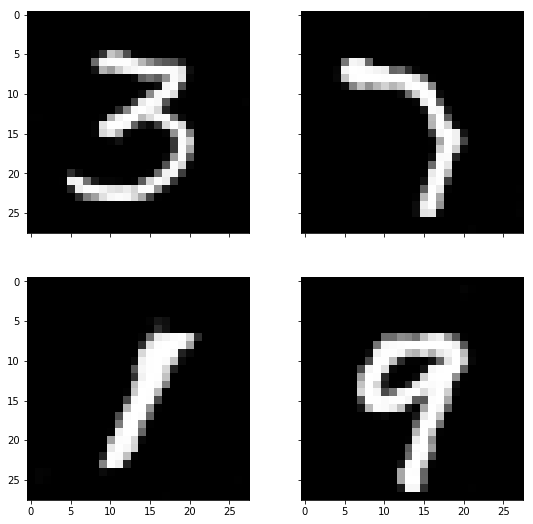

Epoch is 44/100 Generator loss: 2.064336..... Discriminator loss: 0.639168..


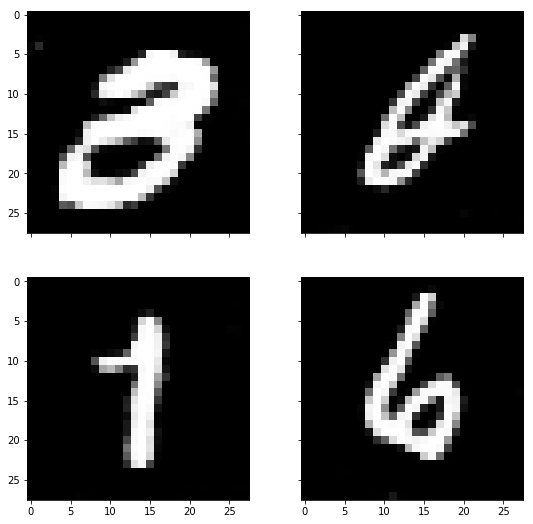

Epoch is 45/100 Generator loss: 1.157380..... Discriminator loss: 0.831558..


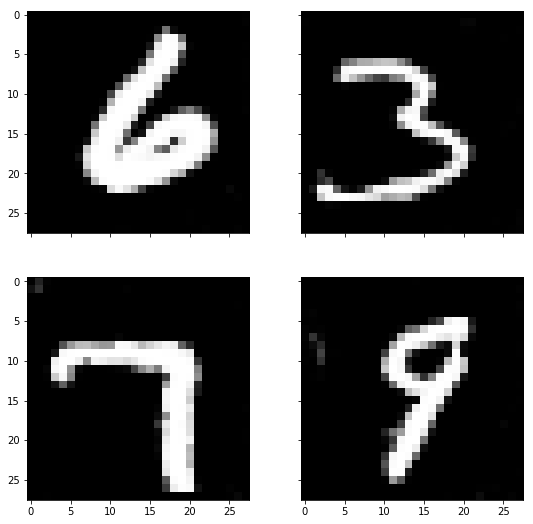

Epoch is 46/100 Generator loss: 1.269165..... Discriminator loss: 0.790748..


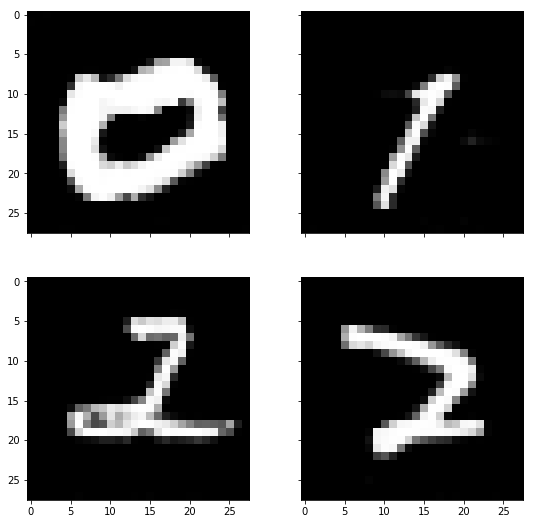

Epoch is 47/100 Generator loss: 1.446341..... Discriminator loss: 0.709786..


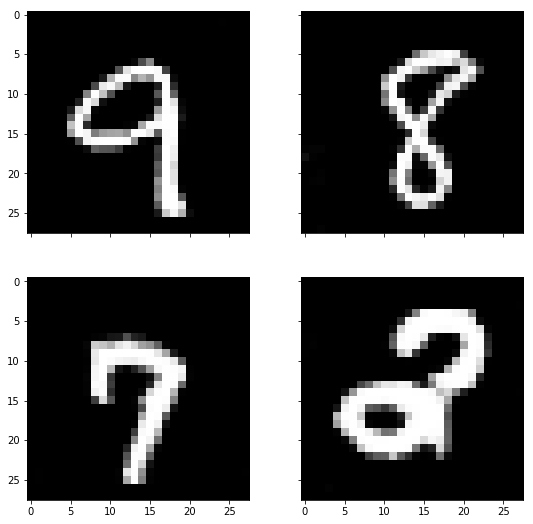

Epoch is 48/100 Generator loss: 1.255673..... Discriminator loss: 0.792352..


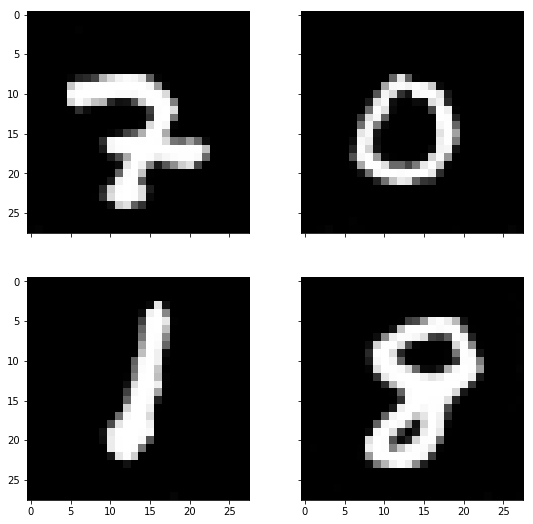

Epoch is 49/100 Generator loss: 2.464717..... Discriminator loss: 0.610237..


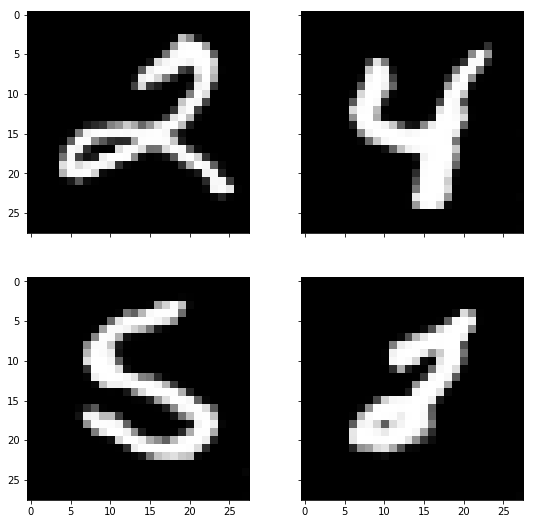

Epoch is 50/100 Generator loss: 0.907160..... Discriminator loss: 1.232779..


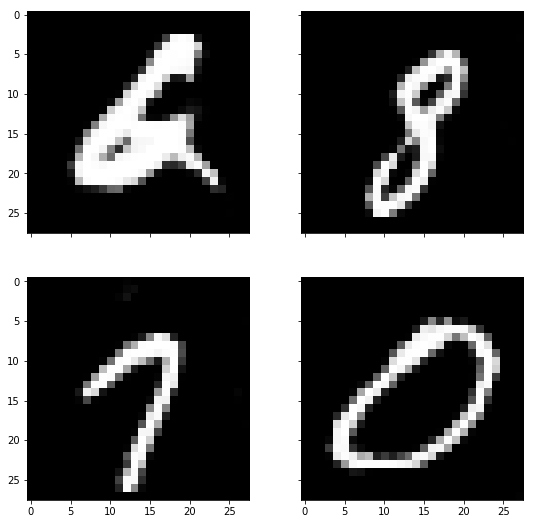

Epoch is 51/100 Generator loss: 1.732240..... Discriminator loss: 0.788320..


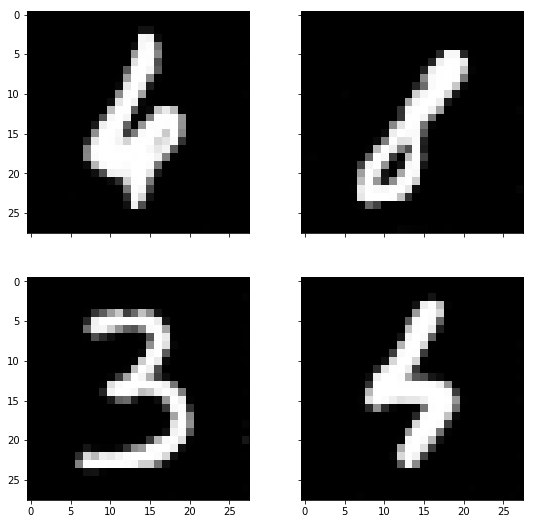

Epoch is 52/100 Generator loss: 1.523524..... Discriminator loss: 0.694880..


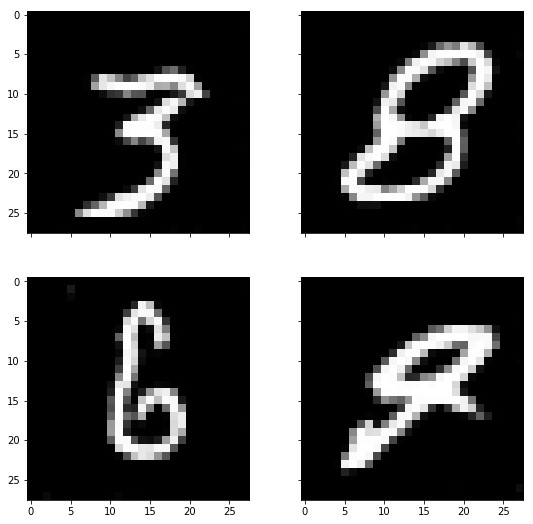

Epoch is 53/100 Generator loss: 1.446120..... Discriminator loss: 0.735619..


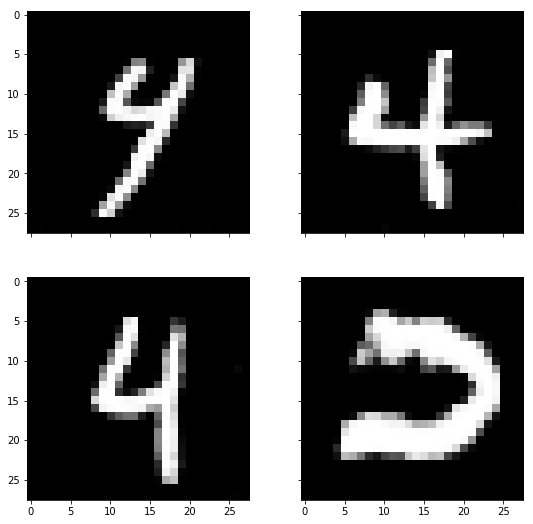

Epoch is 54/100 Generator loss: 1.075255..... Discriminator loss: 0.893391..


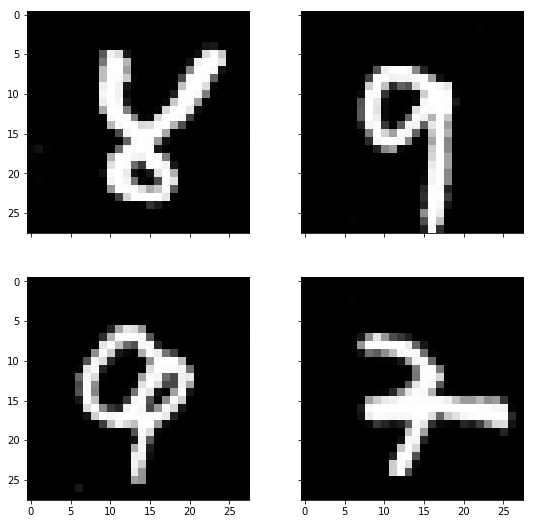

Epoch is 55/100 Generator loss: 0.577488..... Discriminator loss: 1.498703..


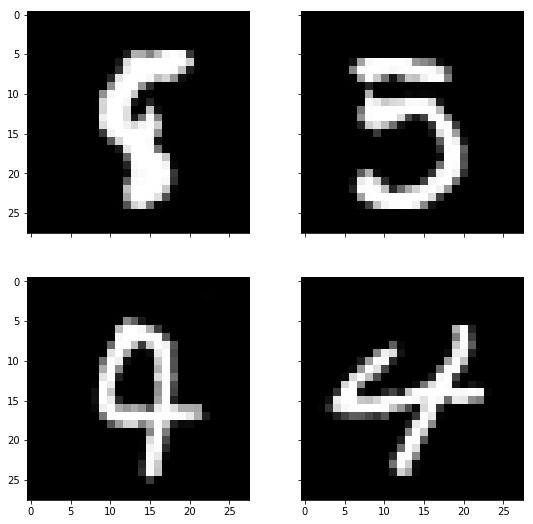

Epoch is 56/100 Generator loss: 0.527459..... Discriminator loss: 1.557335..


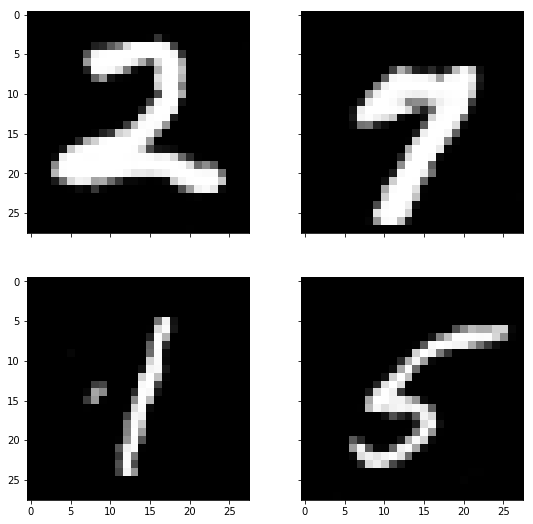

Epoch is 57/100 Generator loss: 1.603939..... Discriminator loss: 0.669809..


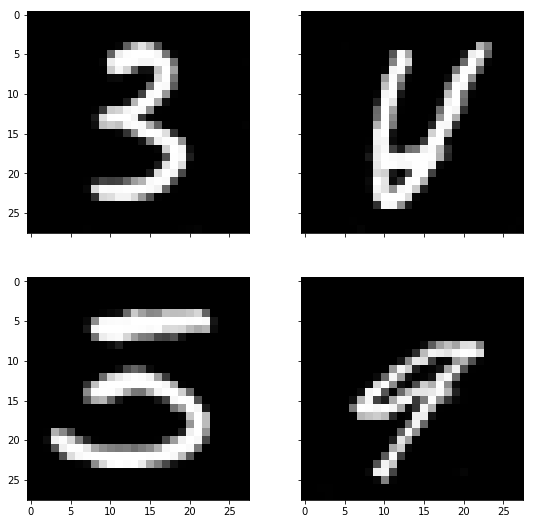

Epoch is 58/100 Generator loss: 1.142308..... Discriminator loss: 0.847705..


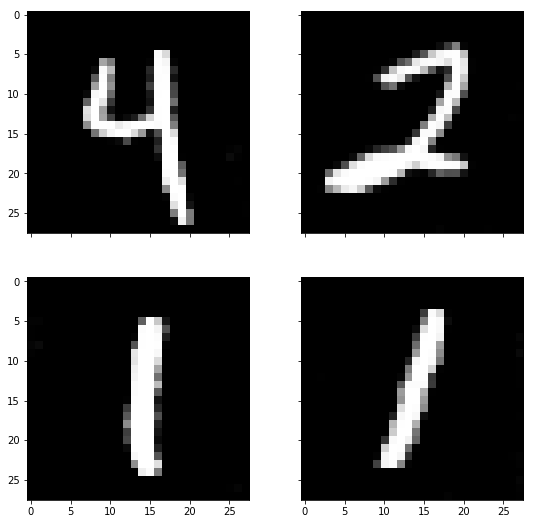

Epoch is 59/100 Generator loss: 1.433471..... Discriminator loss: 0.725270..


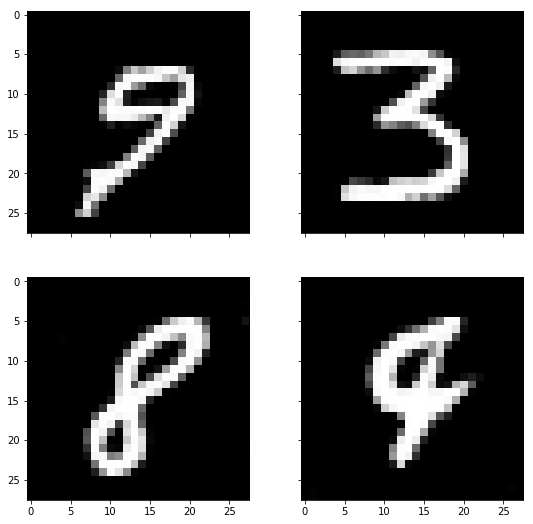

Epoch is 60/100 Generator loss: 1.932768..... Discriminator loss: 0.624355..


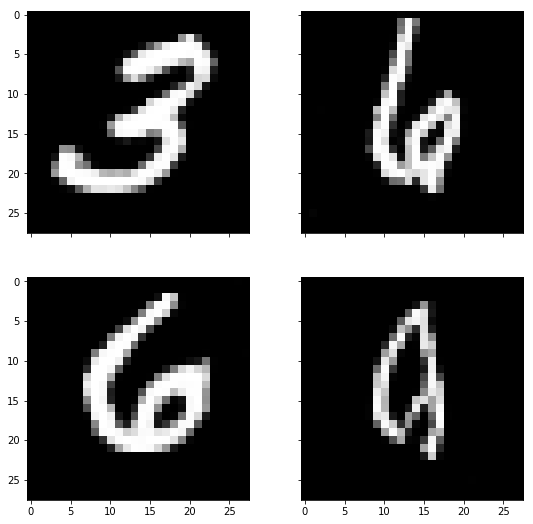

Epoch is 61/100 Generator loss: 1.069533..... Discriminator loss: 0.970248..


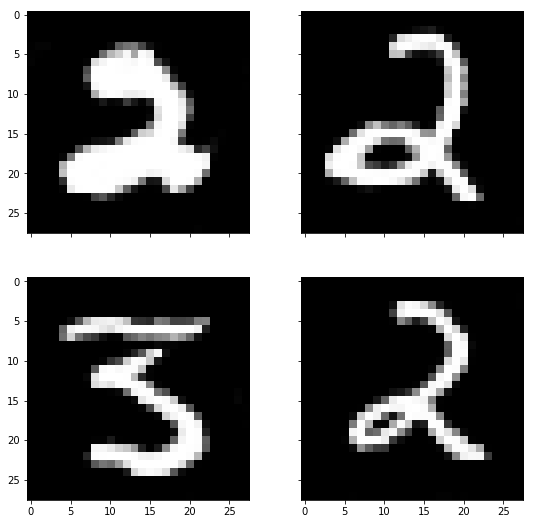

Epoch is 62/100 Generator loss: 2.626964..... Discriminator loss: 0.769865..


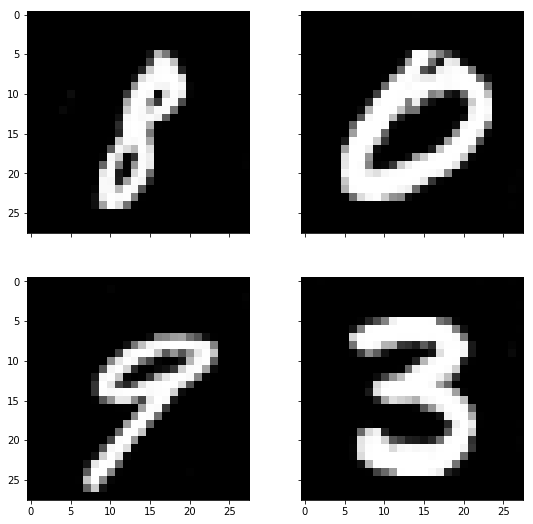

Epoch is 63/100 Generator loss: 1.483900..... Discriminator loss: 0.717089..


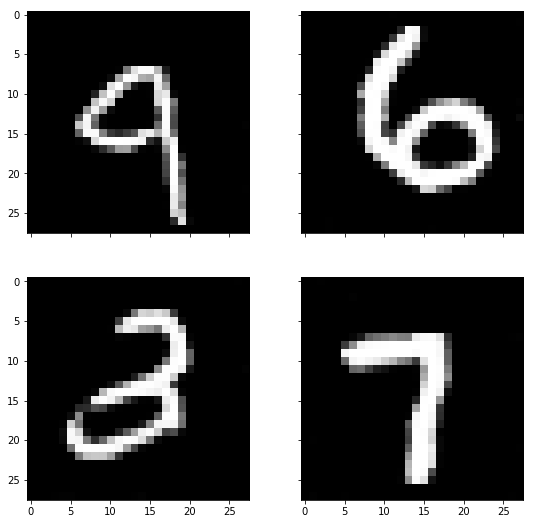

Epoch is 64/100 Generator loss: 2.699588..... Discriminator loss: 0.838742..


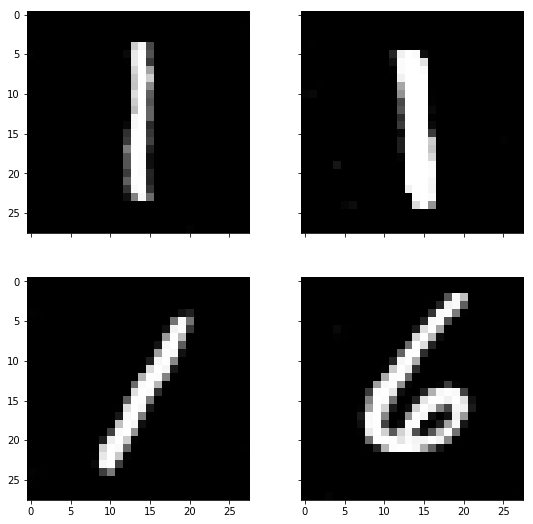

Epoch is 65/100 Generator loss: 1.521939..... Discriminator loss: 0.679931..


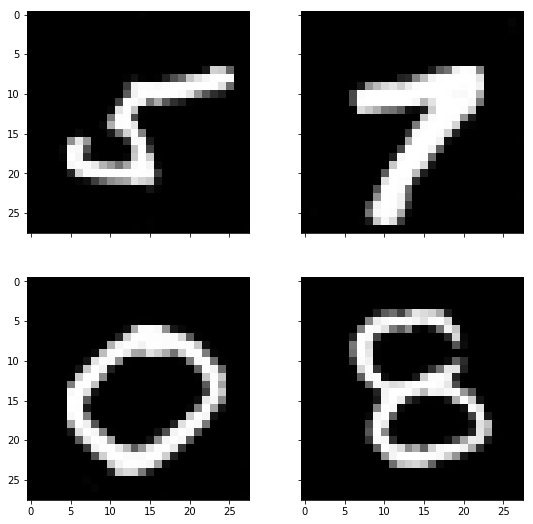

Epoch is 66/100 Generator loss: 1.456140..... Discriminator loss: 0.725038..


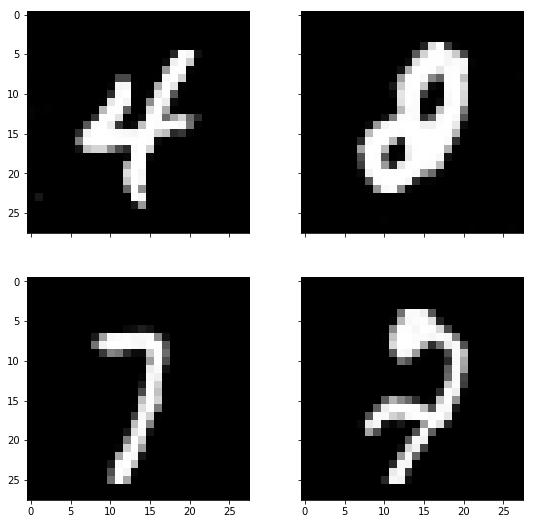

Epoch is 67/100 Generator loss: 2.573778..... Discriminator loss: 1.105770..


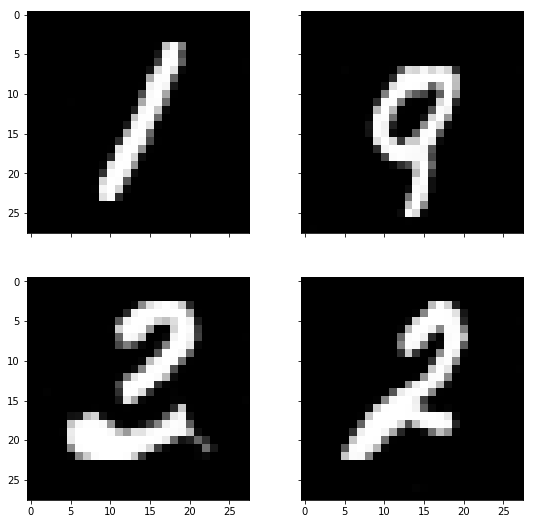

Epoch is 68/100 Generator loss: 2.156955..... Discriminator loss: 0.725036..


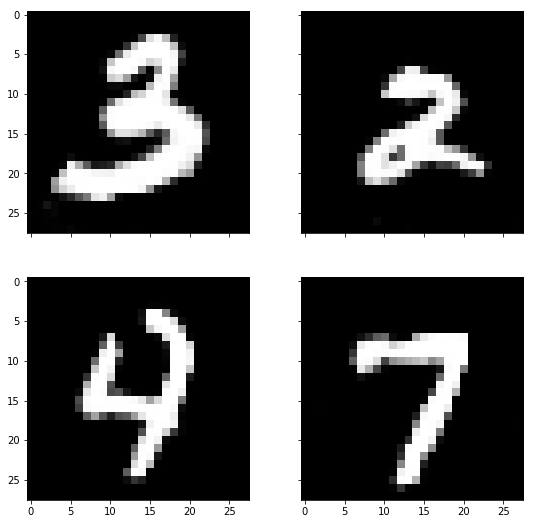

Epoch is 69/100 Generator loss: 1.460897..... Discriminator loss: 0.721874..


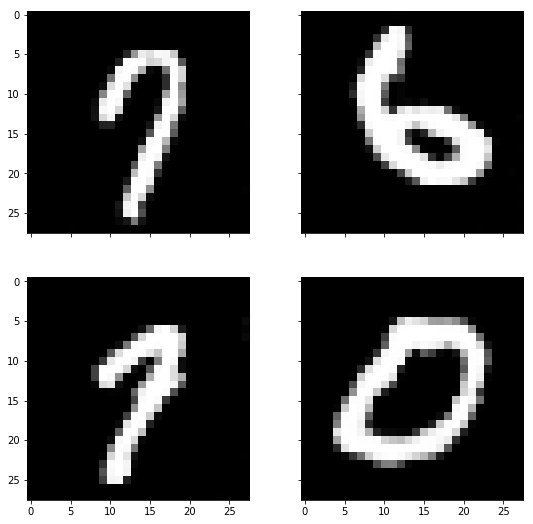

Epoch is 70/100 Generator loss: 0.994549..... Discriminator loss: 0.989553..


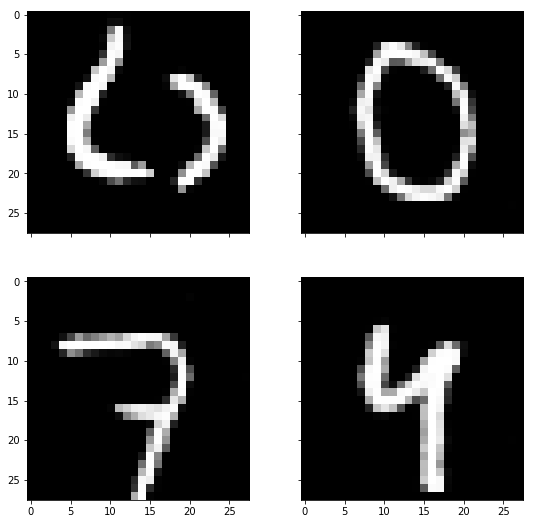

Epoch is 71/100 Generator loss: 2.117481..... Discriminator loss: 0.546595..


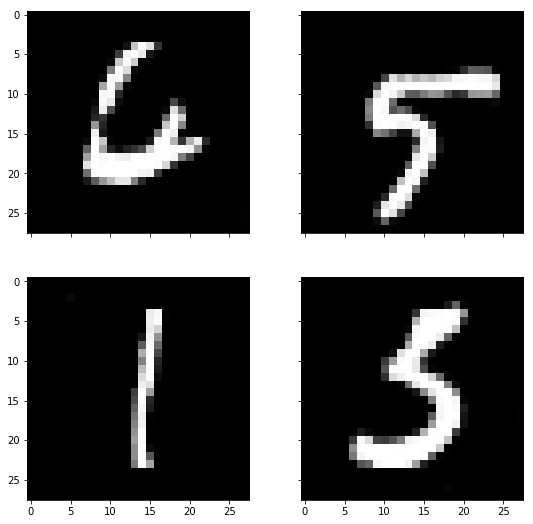

Epoch is 72/100 Generator loss: 1.852060..... Discriminator loss: 0.627087..


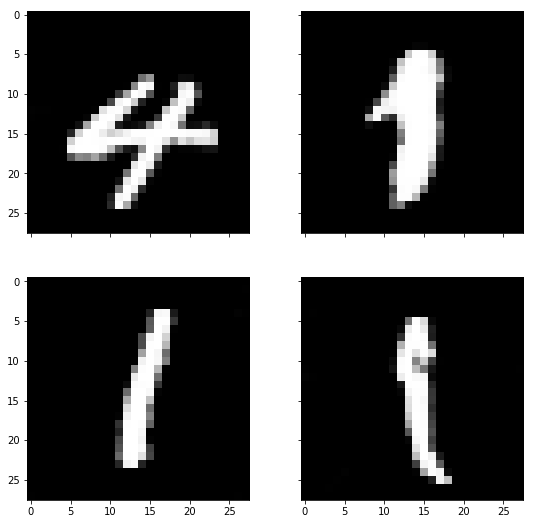

Epoch is 73/100 Generator loss: 1.569466..... Discriminator loss: 0.697202..


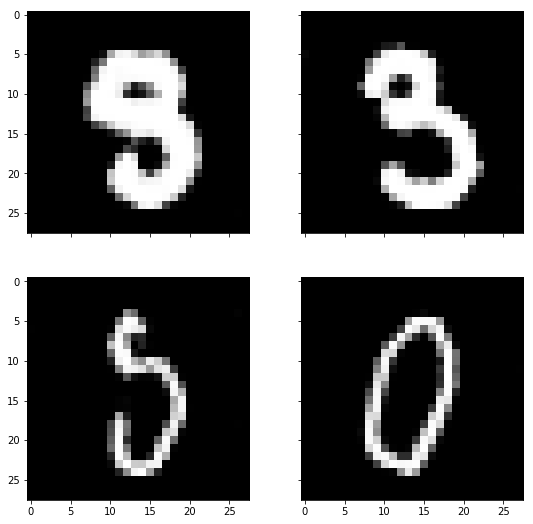

Epoch is 74/100 Generator loss: 6.034176..... Discriminator loss: 2.708605..


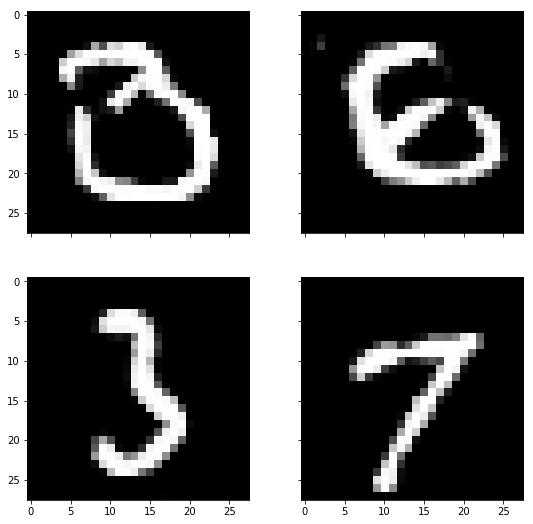

Epoch is 75/100 Generator loss: 1.425287..... Discriminator loss: 0.765388..


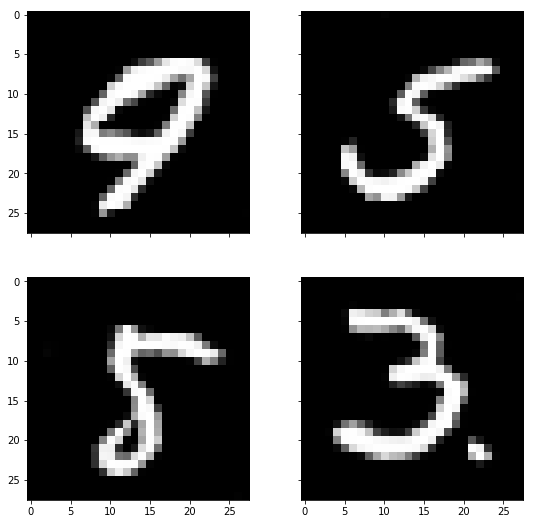

Epoch is 76/100 Generator loss: 1.812658..... Discriminator loss: 0.605762..


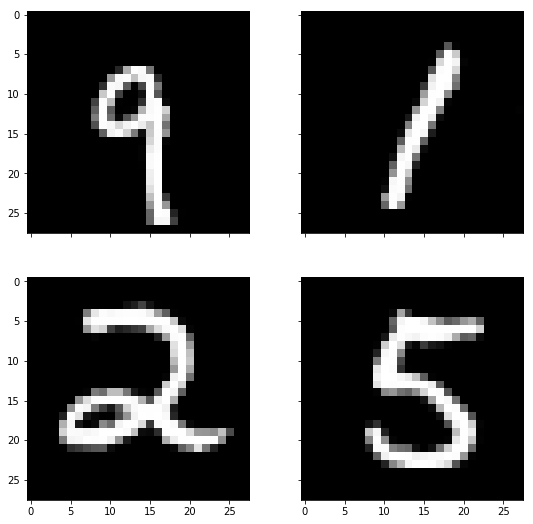

Epoch is 77/100 Generator loss: 0.846295..... Discriminator loss: 1.238035..


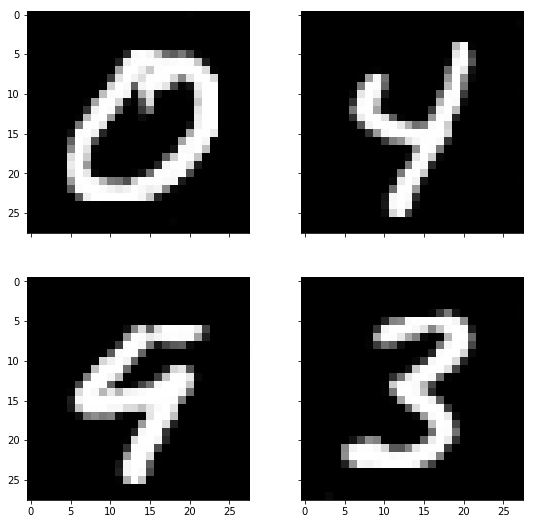

Epoch is 78/100 Generator loss: 1.200480..... Discriminator loss: 0.877894..


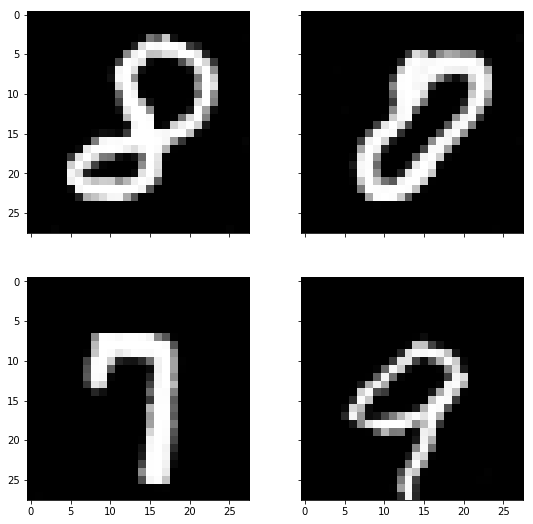

Epoch is 79/100 Generator loss: 2.226380..... Discriminator loss: 0.674336..


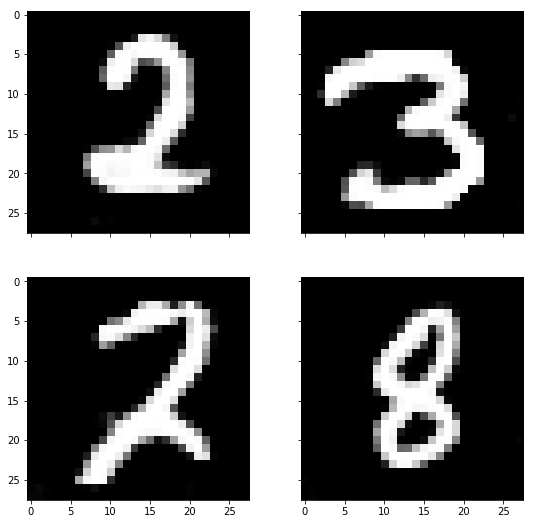

Epoch is 80/100 Generator loss: 1.609672..... Discriminator loss: 0.671927..


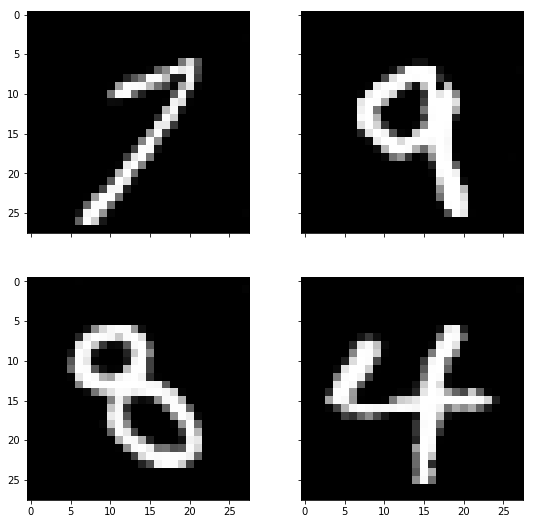

Epoch is 81/100 Generator loss: 1.416931..... Discriminator loss: 0.803911..


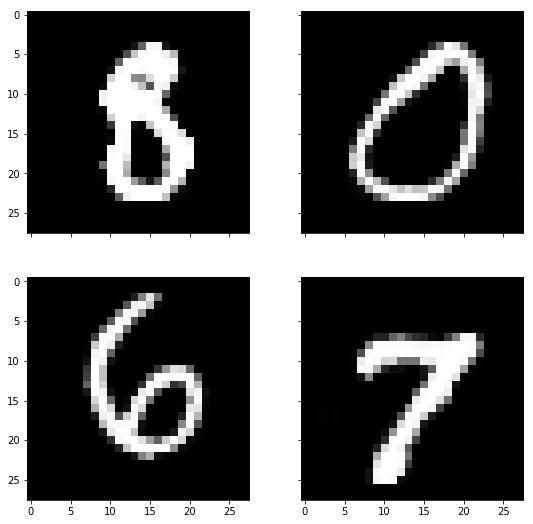

Epoch is 82/100 Generator loss: 2.235795..... Discriminator loss: 0.514423..


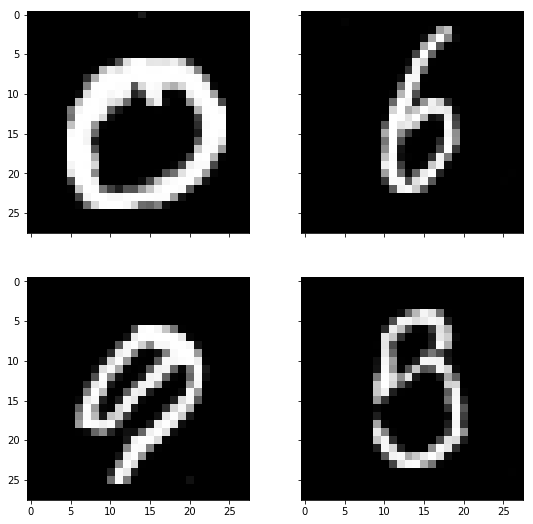

Epoch is 83/100 Generator loss: 2.370097..... Discriminator loss: 0.794027..


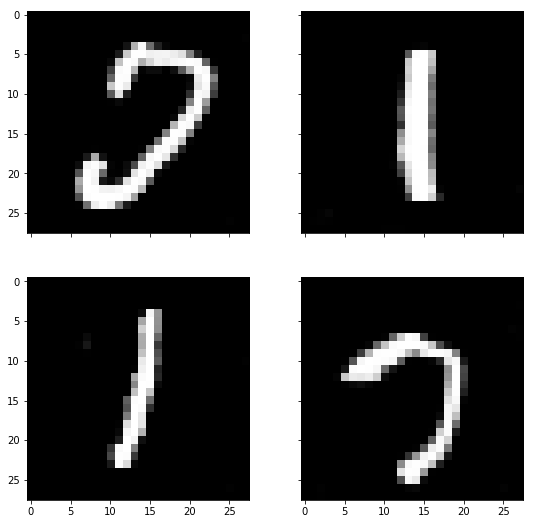

Epoch is 84/100 Generator loss: 1.570381..... Discriminator loss: 0.672826..


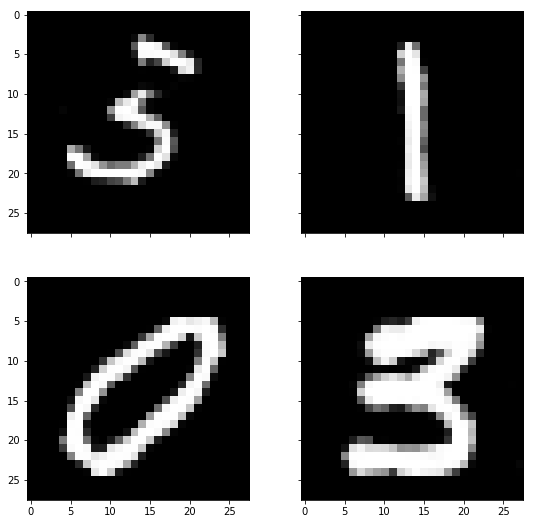

Epoch is 85/100 Generator loss: 1.805994..... Discriminator loss: 0.594167..


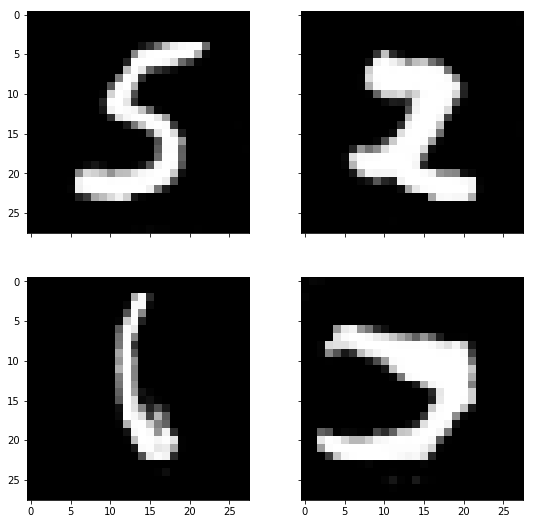

Epoch is 86/100 Generator loss: 2.016313..... Discriminator loss: 0.583612..


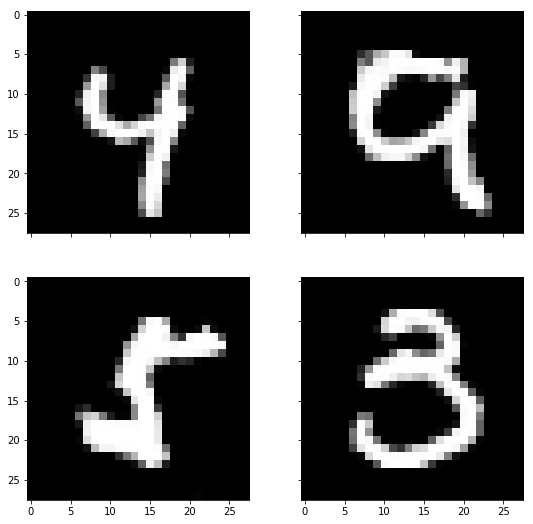

Epoch is 87/100 Generator loss: 1.989873..... Discriminator loss: 0.553133..


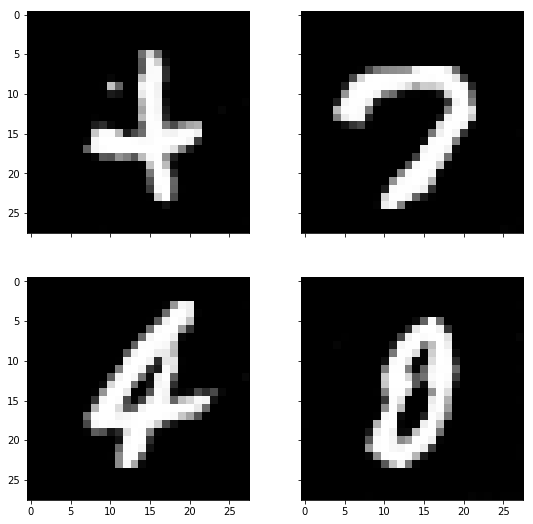

Epoch is 88/100 Generator loss: 2.176530..... Discriminator loss: 0.526288..


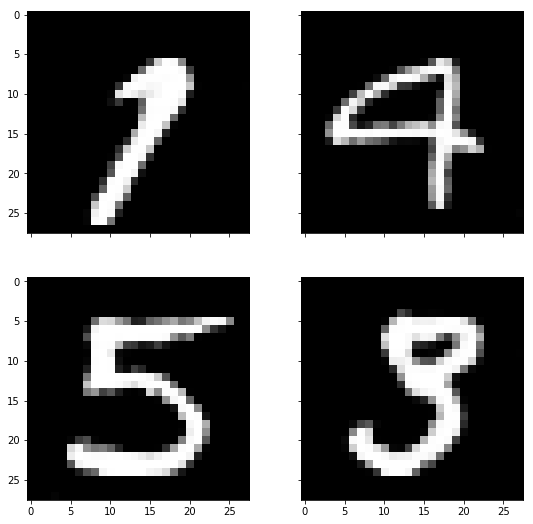

Epoch is 89/100 Generator loss: 2.877692..... Discriminator loss: 0.591875..


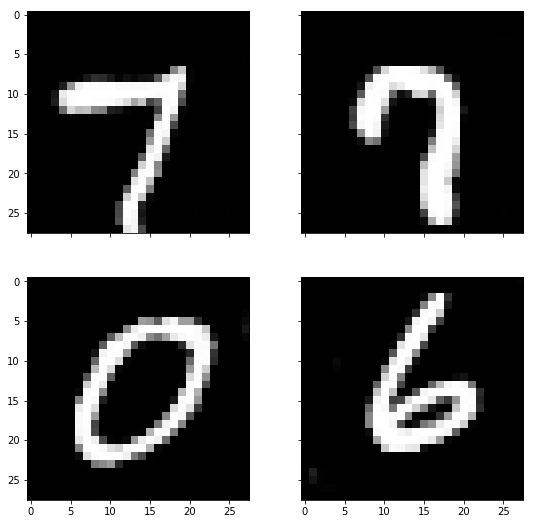

Epoch is 90/100 Generator loss: 2.444685..... Discriminator loss: 0.593444..


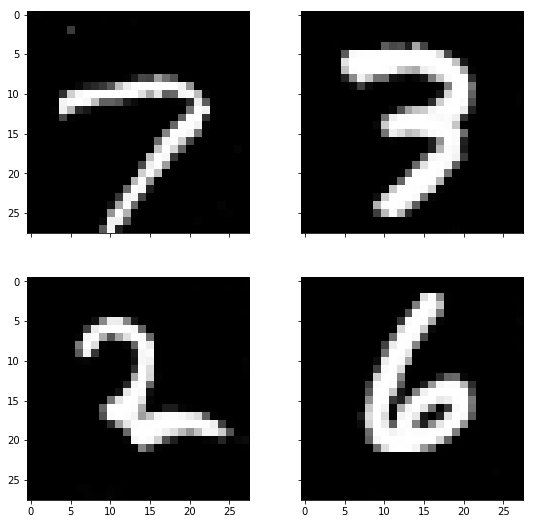

Epoch is 91/100 Generator loss: 2.178839..... Discriminator loss: 0.532202..


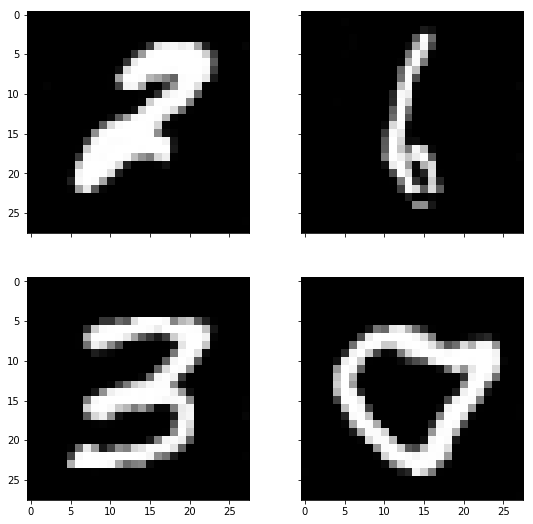

Epoch is 92/100 Generator loss: 3.286962..... Discriminator loss: 1.273180..


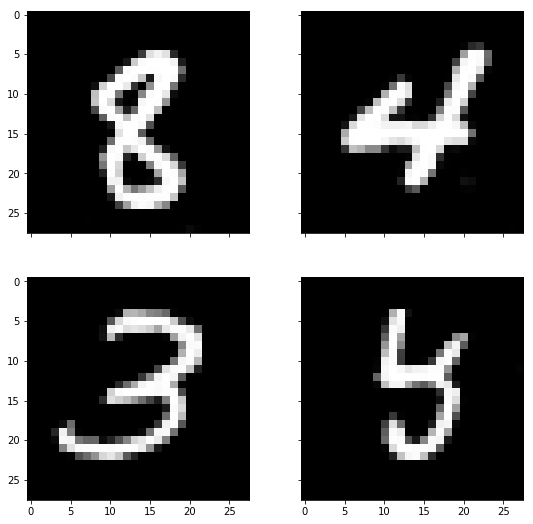

Epoch is 93/100 Generator loss: 2.868307..... Discriminator loss: 0.469630..


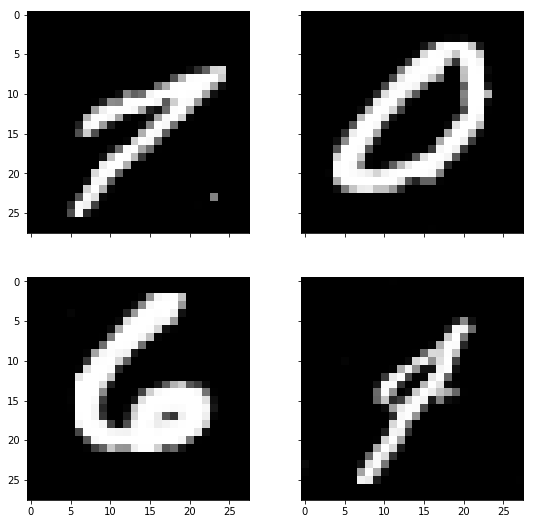

Epoch is 94/100 Generator loss: 1.498648..... Discriminator loss: 0.692503..


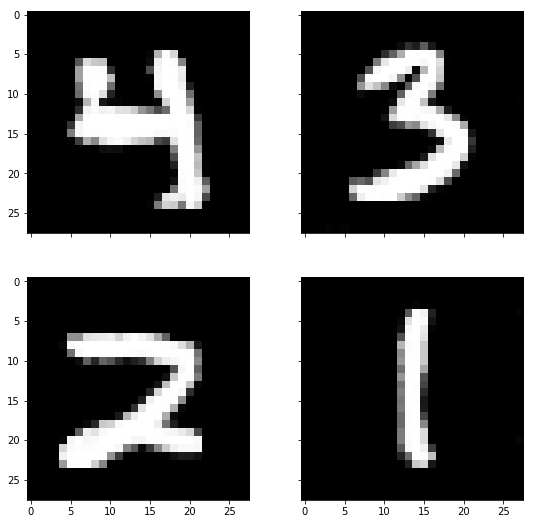

Epoch is 95/100 Generator loss: 2.394500..... Discriminator loss: 0.692609..


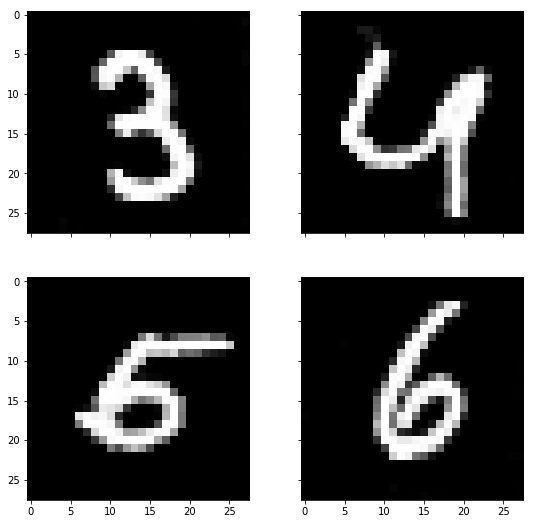

Epoch is 96/100 Generator loss: 2.113836..... Discriminator loss: 0.572845..


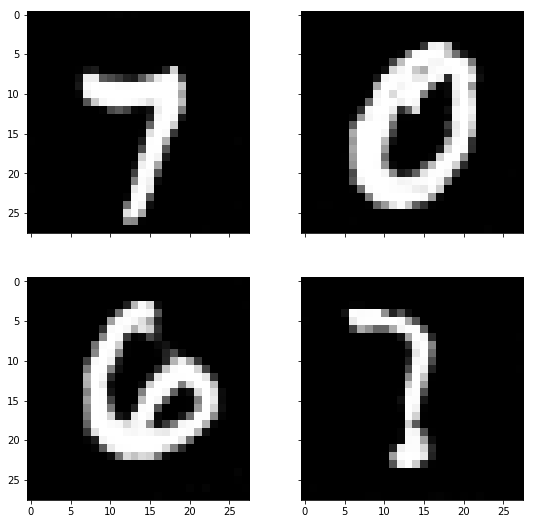

Epoch is 97/100 Generator loss: 1.172109..... Discriminator loss: 0.956837..


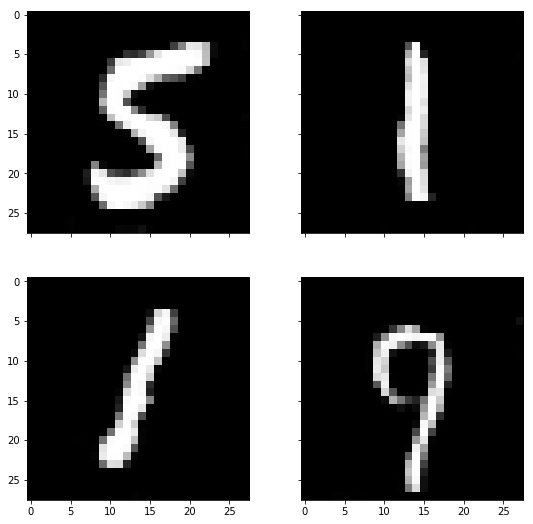

Epoch is 98/100 Generator loss: 2.215225..... Discriminator loss: 0.541528..


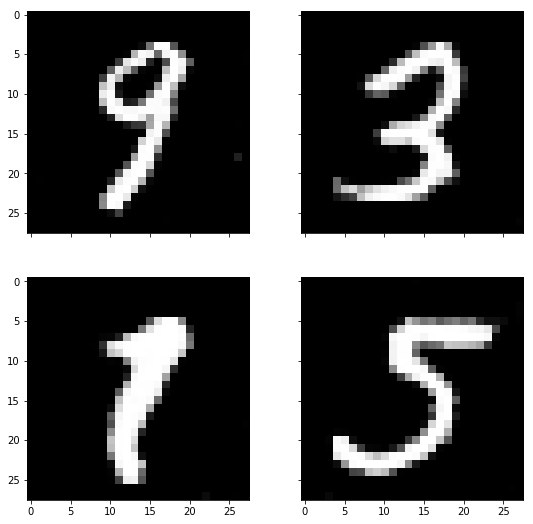

Epoch is 99/100 Generator loss: 2.575546..... Discriminator loss: 0.465959..


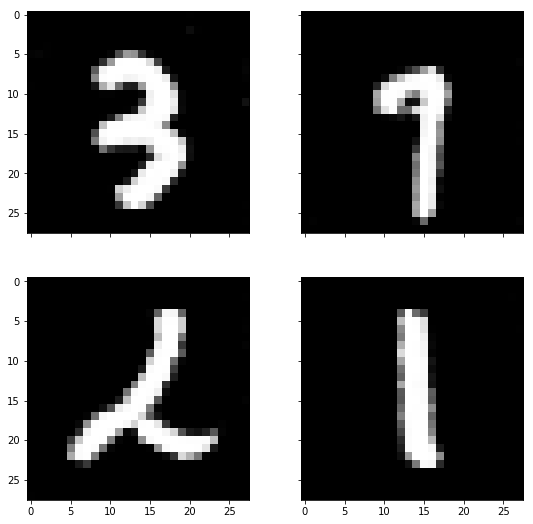

Epoch is 100/100 Generator loss: 1.471251..... Discriminator loss: 0.707912..


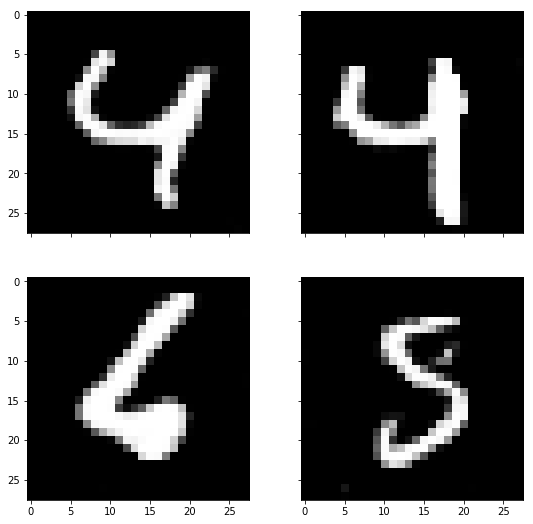

In [67]:
#training code 

epochs =100

samples = []

losses = []

with graph.as_default():
    
    saver = tf.train.Saver()

with tf.Session(graph = graph) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    
    for e in range(epochs):
        
        for ii in range(mnist.train.num_examples//batch_size):
            
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, *input_size))
            
            batch_images = batch_images *2 - 1
            
            batch_z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            
            _ = sess.run(D_opt, feed_dict = {input_real:batch_images, input_gen: batch_z})
            
            _ = sess.run(G_opt, feed_dict = {input_gen: batch_z, input_real : batch_images})
            
            
        #end of each epoch, calculate loss
        
        Genloss = sess.run(G_loss, feed_dict = {input_gen: batch_z, input_real : batch_images})
        
        Disloss = sess.run(D_loss_total, {input_real: batch_images, input_gen: batch_z})
        
        
        print('Epoch is {}/{}' .format (e + 1, epochs),
              
              "Generator loss: {:4f}.....". format(Genloss),
              
              "Discriminator loss: {:4f}..".format(Disloss))
        
        #save losses to visalize learning curves
        
        losses.append((Genloss, Disloss))
        
        
        #sample from generator after each epoch
        
        sample_z = np.random.uniform(-1, 1, size = (8, z_size))
        
        samples_z = sess.run(generator_forward(input_gen, reuse = True, training = False),
                             feed_dict = {input_gen: sample_z, input_real: batch_images })
        
        view_samples(0, [samples_z])
        
        plt.show()
        
        
        #samples.append(samples_z)
        
        saver.save(sess, './checkpoints/generator_covn.ckpt')
        
        
 #save samples after training

   # with open ('train_samples_g.pl', 'wb') as f:
        
       # pl.dump(samples, f)
        
        
        
              
              
        
            
            
            
            
            
            
            
    
    
    
    

# Generator Samples from training

In [0]:
#function to view generator samples

def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize = (9, 9), nrows = 4, ncols = 4, sharey = True, sharex = True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
    
        im = ax.imshow(img.reshape((28,28)), cmap = 'Greys_r')
    
    return fig, axes

In [0]:
_ = view_samples(999, samples)

(<Figure size 648x648 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bdcb94e10>,
       dtype=object))

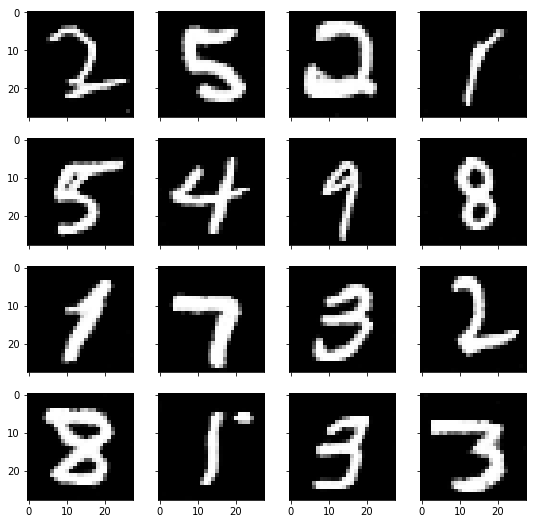

In [87]:
#generate samples using trained generator

with graph.as_default():
    savere = tf.train.Saver()
with tf.Session(graph = graph) as sess:
    checkpoint = tf.train.latest_checkpoint('checkpoints')
    
    savere.restore(sess, checkpoint)
    sample_z = np.random.uniform(-1, 1, size=((16, 100)))
    sample_z = tf.to_float(sample_z)
    gen_samples = sess.run(
                   generator_forward(sample_z, reuse=True, training = False))
                   #feed_dict={gen: sample_z})
view_samples(0, [gen_samples])

In [0]:
import os 
checkpoint_path = "checkpoints/generator_net.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')